# COMP47670 Assignment 1

In [1]:
from alpha_vantage.timeseries import TimeSeries
import csv
import json
import time
import pandas as pd
import datetime
from  sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import seaborn as sns

## Task 1: Defining a Suitable API

The API chosen was Alpha Vantage: https://www.alphavantage.co/.<br>
<br>
Alpha Vantage allows us to look at historical stock data for a range of different companies so we can analyse previous trends which may have existed.<br>
<br>
The Alpha Vantage API allows us to call upon it 500 times a day with a maximum of 5 calls per minute. By creating a free account with Alpha Vantage an API key was recieved.

In [2]:
api_key = 'BMBHG46MNZX3IELN'

## Task 2: Collecting Raw Data in JSON Format

We must first decide which stocks we are to analyse so we can collect the appropriate data. For this assignment, 6 stocks were chosen. Apple, Microsoft, Amazon, Facebook, Tesla and Google. These are perhaps the 6 most dominant companies in the world and so analysing any relations which may exist would be of significant interest.

In [3]:
stockTickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'TSLA', 'GOOGL']

We must then create a function to collect the data using the Alpha Vantage API. We will collect this data in JSON format. Attached with this IPYNB file is a JSON file labelled <i>'json_file.json'</i>. This file contains all of the raw data collected using the Alpha Vantage API.<br>
<br>
The frequency at which data is collected must also be decided. For the purposes of this assignment we will collect data over a period of 1 month for every 5 minute time interval.

In [4]:
#Function to get raw data from api in JSON format
def getRawData(time_interval='5min', api_key=api_key, stockTickers=stockTickers):
    ts = TimeSeries(key=api_key, output_format='json')
    count = 0
    stockDict = {}
    
    for ticker in stockTickers:
        if count == 5:
            print('Too many API calls. Need to wait for 1 minute.')
            print('Waiting...')
            time.sleep(61)
            print('Done Waiting!')
            count = 0
            
        data, meta_data = ts.get_intraday(ticker, time_interval, 'full')
        stockDict[ticker] = data
        count = count + 1
        
    with open('json_file.json', 'w') as json_file:
        json.dump(stockDict, json_file)
    
    json_file.close()

In [5]:
#Set to true to collect data from the Alpha Vantage API
getRaw = False

if getRaw:
    getRawData()

## Task 3: Parsing and Cleaning Raw Data

The raw data must now be parsed and cleaned. The following functions take the raw data we collected in JSON format and creates a CSV file for each stock. The data collected from Alpha Vantage is not inherently clean and a number of data points are missing. We must therefore fill in these missing values.<br>
<br>
The <b>K-Nearest Neighbours</b> algorithm allows us to make predictions about what the missing values may be based on the previous data points in the time series. Using a <b>K-Nearest Neighbours</b> predictor we can fill in the missing values for each stock.

In [6]:
#Function to take in a JSON file and output a csv file
def createCSV(stockTicker, jsonFile='json_file.json'):
    with open(jsonFile, "r") as json_file:
        json_data = json.load(json_file)
        
    json_file.close()
    
    data_file = open(f'{stockTicker}_data_file.csv', 'w', newline='')
    csv_writer = csv.writer(data_file)
    
    header = ['timestamp', 'close']
    csv_writer.writerow(header)
    
    i = 0
    while i < len(list(json_data[stockTicker])):
        timestamp = list(json_data[stockTicker])[i]
        closeValue = list(json_data[stockTicker].values())[i]['4. close']
        csv_writer.writerow([timestamp, closeValue])
        i = i + 1
    
    data_file.close()

In [7]:
#Function to fill in missing values using K-Nearest Neighbours algorithm
def cleanCSVfile(csv_file, stockTicker):
    df = pd.read_csv(csv_file)
    train_df = df.copy()
    
    start = '2021-02-08  08:00:00'
    start = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    
    end = '2021-03-05 20:00:00'
    end = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    
    actualDates = pd.to_datetime(df['timestamp']).dt.date.unique()
       
    r = pd.date_range(start=start, end=end, freq='5Min')
    df = df.set_index('timestamp').reindex(r.strftime('%Y-%m-%d %H:%M:%S')).rename_axis('timestamp').reset_index()
    train_df = train_df.set_index('timestamp').reindex(r.strftime('%Y-%m-%d %H:%M:%S')).rename_axis('timestamp').reset_index()

    df['date'] = pd.to_datetime(df['timestamp']).dt.date
    df['time'] = pd.to_datetime(df['timestamp']).dt.time
    
    stockMarketOpen = datetime.datetime.strptime('08:00:00', '%H:%M:%S').time()
    stockMarketClose = datetime.datetime.strptime('17:00:00', '%H:%M:%S').time()
        
    df = df.loc[(df['date'].isin(actualDates)) & (df['time'] <= stockMarketClose) & (df['time'] >= stockMarketOpen)]
    
    numMissingPoints = len(df.loc[np.isnan(df['close']) == True])
    print(f'Number of data points missing for {stockTicker} = {numMissingPoints}')
    
    train_df['prevclose1'] = train_df['close'].shift(1)
    train_df['prevclose2'] = train_df['close'].shift(2)
    train_df['prevclose3'] = train_df['close'].shift(3)
    
    train_df = train_df.loc[(np.isnan(train_df['close']) == False) & (np.isnan(train_df['prevclose1']) == False) & 
                            (np.isnan(train_df['prevclose2']) == False) & (np.isnan(train_df['prevclose3']) == False)]
    
    X_train = np.array(train_df[['prevclose1', 'prevclose2', 'prevclose3']]).reshape(len(train_df), len(train_df.columns)-2)
    Y_train = np.array(train_df['close'])
    
    neigh = KNeighborsRegressor(n_neighbors=10)
    neigh.fit(X_train, Y_train)
    
    prevCloses = deque(maxlen=len(train_df.columns)-2)
    adjustedClose = []
    isAdjusted = []
    
    for index, row in df.iterrows():
        if np.isnan(row['close']):
            val = neigh.predict([np.array(prevCloses)])[0]
            adjustedClose.append(val)
            prevCloses.appendleft(val)
            isAdjusted.append(1)
    
        elif not np.isnan(row['close']):
            prevCloses.appendleft(row['close'])
            adjustedClose.append(row['close'])
            isAdjusted.append(0)
            
    df['adjustedClose'] = adjustedClose
    df['isAdjusted'] = isAdjusted
    
    df = df.reset_index()[['timestamp', 'close', 'adjustedClose', 'isAdjusted']]
    
    return df

In [8]:
#Set to true to create CSV files for all stocks
makeCSV = True

dataframes = {}

for stockTicker in stockTickers:
    print(f'Creating dataframe for {stockTicker}')
    
    if makeCSV:
        createCSV(stockTicker)
        
    dataframes[stockTicker] = cleanCSVfile(f'{stockTicker}_data_file.csv', stockTicker)
    
    print(f'{stockTicker} dataframe has been created\n')

Creating dataframe for AAPL
Number of data points missing for AAPL = 0
AAPL dataframe has been created

Creating dataframe for MSFT
Number of data points missing for MSFT = 19
MSFT dataframe has been created

Creating dataframe for AMZN
Number of data points missing for AMZN = 102
AMZN dataframe has been created

Creating dataframe for FB
Number of data points missing for FB = 32
FB dataframe has been created

Creating dataframe for TSLA
Number of data points missing for TSLA = 0
TSLA dataframe has been created

Creating dataframe for GOOGL
Number of data points missing for GOOGL = 291
GOOGL dataframe has been created



We must now ensure that the <b>K-Nearest Neighbours</b> method used to fill in missing data points has produced reasonable predictions. The following function graphs how each stock changes over the designated time period of 1 month and pinpoints exactly which values were predicted by the <b>K-Nearest Neighbours</b> algorithm.

In [9]:
def graphFullDataset(data, stock):
    df = data.reset_index()
    
    df1 = df.loc[df['isAdjusted'] == 0]
    df2 = df.loc[df['isAdjusted'] == 1]
    
    plt.scatter(df2['index'], df2['adjustedClose'], marker = '.', color = 'r', zorder = 1, label='Predicted Prices')
    plt.plot(df1['index'], df1['adjustedClose'], zorder = 0, label='Actual Prices')
    plt.title(f'{stock}')
    plt.xlabel('Timestep')
    plt.ylabel('Stock price')
    plt.legend()

    plt.show()

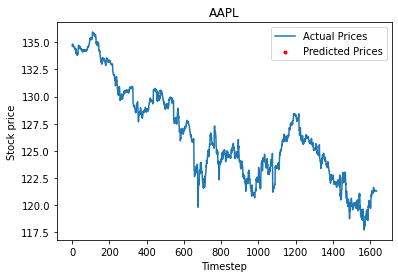

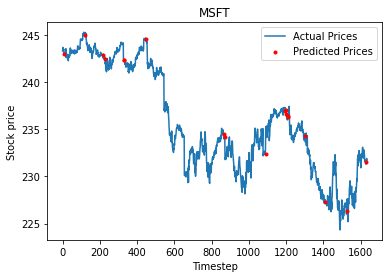

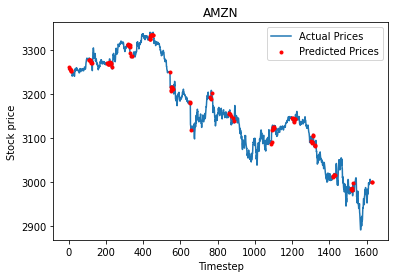

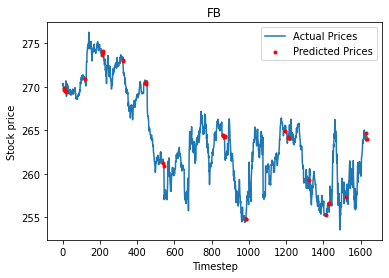

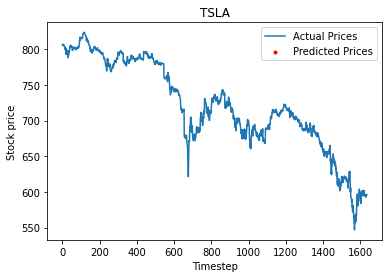

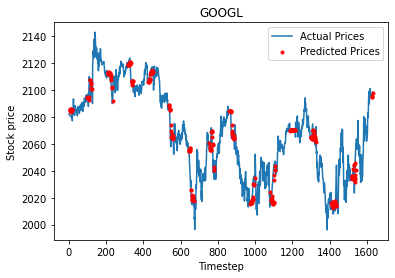

In [10]:
for dataframe in dataframes:
    graphFullDataset(dataframes[dataframe], dataframe)

It appears that all the points predicted by our <b>K-Nearest Neighbours</b> algorithm follow the general trend of the stock prices. There are no extreme outliers and so for the purposes of this assignment we can assume that these predicted values are within a reasonable level of accuracy of the actual stock price. However, it should be noted that if the aim of this assignment was to predict stock prices more care would be needed in the construction of our prediction algorithm.

## Task 4: Feature Extraction

In stock trading, traders will make decisions on whether to buy or sell stocks based off of a number of <b>technical indicators</b>. The next task is therefore to use the data given by Alpha Vantage and derive some of these <b>technical indicators</b>. The Simple Moving Average (SMA) and Relative Strength Index (RSI) are the two technical indicators which will be considered.
<br>
<br>

<u><b>Simple Moving Average (SMA)</b></u>
<br>
The Simple Moving Average is defined by adding recent prices and then dividing that figure by the number of time periods in the calculation average.

$$ SMA = \frac{A_1 + A_2 + ...+ A_n}{N} $$
<br>
<br>

<u><b>Relative Strength Index (RSI)</b></u>
<br>
The Relative Strength Index measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock.

$$ RSI =  100 - \frac{100}{1 + RS} $$
<br>
$$ RS = \frac{Average Gain}{Average Loss} $$
<br>
<br>
Written below are some functions to calculate these technical indicators.

In [11]:
#Function to calculate the SMA at each timestep
def SMA(data, stock, N = 14):
    df = data.copy()
    
    df[f'{stock}_SMA'] = df.loc[:, ['adjustedClose']].rolling(N, min_periods=1).mean()

    return df

In [12]:
#Function to calculate the RSI at each timestep
def RSI(data, stock, N = 14):
    df = data.copy()
    
    num = len(df)

    df['gain'] = 0
    df['loss'] = 0
    df['percent_gain'] = 0
    df['percent_loss'] = 0

    df['average_gain'] = 0
    df['average_loss'] = 0

    close_col_num = df.columns.get_loc('adjustedClose')
    gain_col_num = df.columns.get_loc('gain')
    loss_col_num = df.columns.get_loc('loss')
    pergain_col_num = df.columns.get_loc('percent_gain')
    perloss_col_num = df.columns.get_loc('percent_loss')
    average_gain_col_num = df.columns.get_loc('average_gain')
    average_loss_col_num = df.columns.get_loc('average_loss')

    df.loc[df['adjustedClose'].pct_change() > 0, 'percent_gain'] = 100*df['adjustedClose'].pct_change()
    df.loc[df['adjustedClose'].pct_change() < 0, 'percent_loss'] = -100*df['adjustedClose'].pct_change()

    df['average_gain'] = df['average_gain'].rolling(N, min_periods=1).mean()
    df['average_loss'] = df['average_loss'].rolling(N, min_periods=1).mean()

    j = N

    while j < num:
        previous_average_gain = df.iloc[j - 1, average_gain_col_num]
        current_gain = df.iloc[j, pergain_col_num]
        df.iloc[j, average_gain_col_num] = ((N - 1)*previous_average_gain + current_gain)/N
    
        previous_average_loss = df.iloc[j - 1, average_loss_col_num]
        current_loss = df.iloc[j, perloss_col_num]
        df.iloc[j, average_loss_col_num] = ((N - 1)*previous_average_loss + current_loss)/N
    
        j = j + 1
    
    df['RS'] = df['average_gain']/df['average_loss']
    df[f'{stock}_RSI'] = 100 - (100/(1 + df['RS']))

    df = df.drop(['gain', 'loss', 'percent_gain', 'percent_loss', 'average_gain', 'average_loss', 'RS'], 
                 axis=1).loc[np.isnan(df[f'{stock}_RSI']) == False]
    
    return df

In [13]:
#Add the technical indicators to the dataframes
for stockTicker in stockTickers:
    dataframes[stockTicker] = SMA(dataframes[stockTicker], stockTicker)
    dataframes[stockTicker] = RSI(dataframes[stockTicker], stockTicker)

Lastly, to get an accurate representation of the correlation which may exist between stocks, we must compare the percentage changes of the close price and SMA rather than directly correlating these values. This is to ensure we are comparing the changes occurring in each stock rather than the magnitude. As RSI is already a percentage value it is not required to calculate its percentage change.

In [14]:
#Calculate the percentage changes of close price and SMA
for stockTicker in stockTickers:
    dataframes[stockTicker][f'{stockTicker}_Close_PctChange'] = dataframes[stockTicker]['adjustedClose'].pct_change()*100
    dataframes[stockTicker][f'{stockTicker}_SMA_PctChange'] = dataframes[stockTicker][f'{stockTicker}_SMA'].pct_change()*100
    dataframes[stockTicker] = dataframes[stockTicker].loc[np.isnan(dataframes[stockTicker][f'{stockTicker}_SMA_PctChange'])
                                                                   == False]

## Task 5: Analysing the Results

Before proceeding, we should ensure our cleaned datasets are full and have no missing values.

In [15]:
for dataframe in dataframes:
    print(f'{dataframe} Missing Values:')
    print(dataframes[dataframe].isnull().sum())
    print('\n')

AAPL Missing Values:
timestamp               0
close                   0
adjustedClose           0
isAdjusted              0
AAPL_SMA                0
AAPL_RSI                0
AAPL_Close_PctChange    0
AAPL_SMA_PctChange      0
dtype: int64


MSFT Missing Values:
timestamp                0
close                   18
adjustedClose            0
isAdjusted               0
MSFT_SMA                 0
MSFT_RSI                 0
MSFT_Close_PctChange     0
MSFT_SMA_PctChange       0
dtype: int64


AMZN Missing Values:
timestamp                0
close                   96
adjustedClose            0
isAdjusted               0
AMZN_SMA                 0
AMZN_RSI                 0
AMZN_Close_PctChange     0
AMZN_SMA_PctChange       0
dtype: int64


FB Missing Values:
timestamp              0
close                 30
adjustedClose          0
isAdjusted             0
FB_SMA                 0
FB_RSI                 0
FB_Close_PctChange     0
FB_SMA_PctChange       0
dtype: int64


TSLA Missing Value

All values which are missing for the 'close' columns have been dealt with earlier by our <b>K-Nearest Neighbours</b> algorithm by creating an 'adjustedClose' column. Therefore, there appears to be no missing data points in any of our datasets. We can now examine the descriptive statistics relating to each of our 6 companies.

In [16]:
for dataframe in dataframes:
    print(f'{dataframe} Descriptive Statistics:')
    print(dataframes[dataframe].describe())
    print('\n')
    print('\n')

AAPL Descriptive Statistics:
             close  adjustedClose  isAdjusted     AAPL_SMA     AAPL_RSI  \
count  1620.000000    1620.000000      1620.0  1620.000000  1620.000000   
mean    126.356842     126.356842         0.0   126.409881    48.342427   
std       4.320073       4.320073         0.0     4.319095    13.141406   
min     117.720000     117.720000         0.0   118.366050    10.325677   
25%     123.040075     123.040075         0.0   123.076075    39.213223   
50%     125.797500     125.797500         0.0   125.859957    48.330252   
75%     129.522500     129.522500         0.0   129.622955    57.475405   
max     135.930000     135.930000         0.0   135.774286   100.000000   

       AAPL_Close_PctChange  AAPL_SMA_PctChange  
count           1620.000000         1620.000000  
mean              -0.006075           -0.006394  
std                0.225987            0.055172  
min               -1.966693           -0.187409  
25%               -0.100793           -0.0372

It should be noted that the mean values for 'close' and 'adjustedClose' for each stock are reasonably similar. We can therefore gain confidence that our <b>K-Nearest Neighbours</b> algorithm was sucessful in its predictions.
<br>
<br>
For all of these stocks, the 50% quartile value is slightly closer to the 25% quartile value than the 75% quartile value indicating a slight downward trend for each stock. This can be confirmed by viewing the figures above plotting our <b>K-Nearest Neighbours</b> prediction values upon the stock data. In all of these figures there appears to be a general downward trend.

Now that we have our full data we can compare the different stocks to get insight into relationships which may exist. The following code creates a number of correlation heatmaps describing how the closing price, the SMA and the RSI of each company stock correlates with eachother.

In [17]:
#Function to create correlation heatmaps
def createHeatMap(data, title):
    sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
    fig=plt.gcf()
    fig.set_size_inches(10,10)
    plt.title(f'{title} Correlation Heatmap\n', fontsize=20)
    plt.show()

In [18]:
pct_change_close = []
pct_change_sma = []
rsi = []
ti_dataframes = {}

for stockTicker in stockTickers:
    pct_change_close.append(dataframes[stockTicker][f'{stockTicker}_Close_PctChange'])
    pct_change_close_df = pd.concat(pct_change_close, axis=1)
    ti_dataframes['Percentage Change in Close Price'] = pct_change_close_df
    
    pct_change_sma.append(dataframes[stockTicker][f'{stockTicker}_SMA_PctChange'])
    pct_change_sma_df = pd.concat(pct_change_sma, axis=1)
    ti_dataframes['Percentage Change in SMA'] = pct_change_sma_df
    
    rsi.append(dataframes[stockTicker][f'{stockTicker}_RSI'])
    rsi_df = pd.concat(rsi, axis=1)
    ti_dataframes['RSI'] = rsi_df

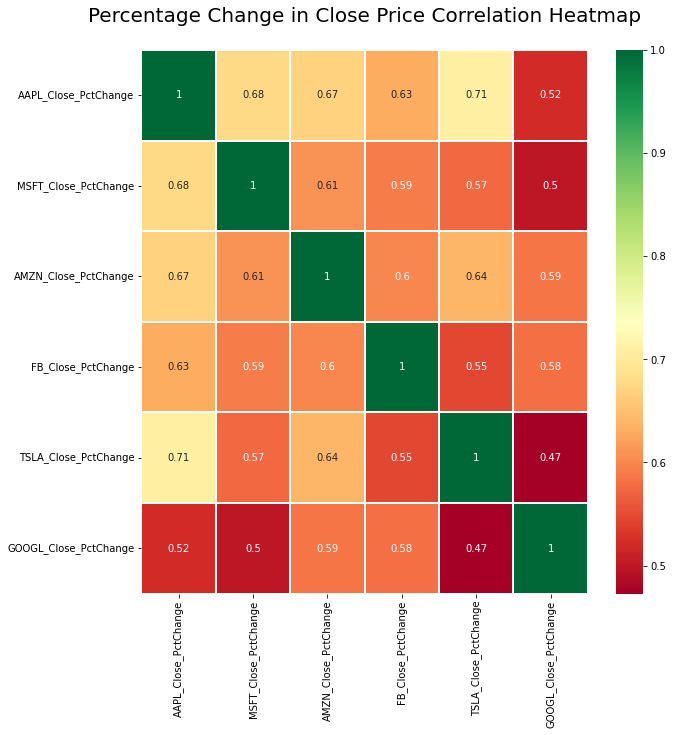

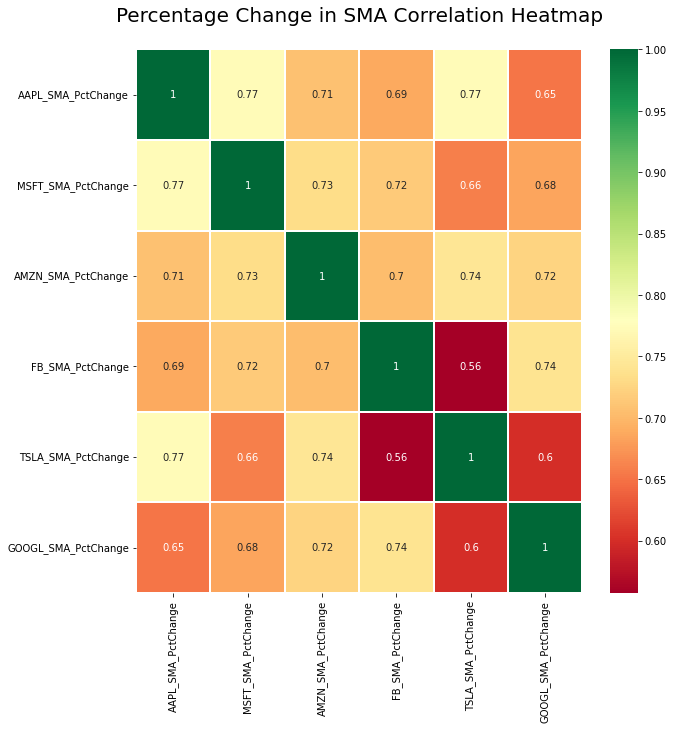

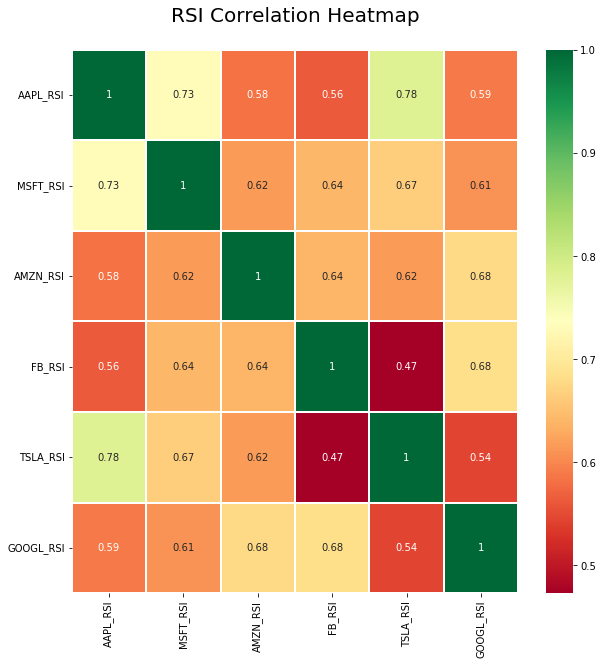

In [19]:
for ti_dataframe_name in ti_dataframes:
    createHeatMap(ti_dataframes[ti_dataframe_name], ti_dataframe_name)
    print('\n')
    print('\n')

By examining these heatmaps, there appears to be significant correlations between all of these stocks. While some are more correlated then others (Apple and Tesla) even the weaker correlated stocks will have some relationship. This is to be expected. All these companies invest huge sums of money in order to be innovative and out perform competitors. They are all constantly trying to be leaders in the industry and so it makes sense that such large companies would generally trend in the same direction. They can't let one of the other companies gain the upper hand on them and so if one company sees an increase in its stock prices, the other companies will make sure they see an increase too. If one company sees a decrease in its stock prices, this is likely due to some uncontrollable reason which will affect the other companies as well.
<br>
<br>
In conclusion, it appears that over the past month the stock prices of these tech giants have generally trended in the same direction. They will rise together or more accurately based off the data analysed in this assignment, they will suffer together.